# Random Forest Regressor

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv('../data/filtered/processedData.csv')

In [2]:
X = df.drop("SalePrice", axis=1)
y = np.log1p(df["SalePrice"])

# Split the data into training and validation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# Identify categorical columns
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns

# Fill NaNs in categorical columns with 'N/A'
X_train[cat_cols] = X_train[cat_cols].fillna("N/A")

# Apply one-hot encoding
X_train_encoded = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)


In [4]:
# Make sure test set has same columns as train set
X_val_encoded = pd.get_dummies(X_val, columns=cat_cols, drop_first=True)
X_val_encoded = X_val_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_encoded, y_train)


RandomForestRegressor(random_state=42)

In [5]:
y_pred = rf_model.predict(X_val_encoded)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"Validation RMSE: {rmse:.2f}")


Validation RMSE: 0.16


In [6]:
# Predict log(SalePrice)
y_pred_log = rf_model.predict(X_val_encoded)

# Reverse the log-transform
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_val)

# Then compute RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Validation RMSE (log-reversed): {rmse:.2f}")


Validation RMSE (log-reversed): 32002.81


In [7]:
importances = rf_model.feature_importances_
feature_names = X_train_encoded.columns
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)
print(importance_df.head(10))

          feature  importance
3     OverallQual    0.552231
15      GrLivArea    0.121929
23     GarageArea    0.045319
11    TotalBsmtSF    0.044993
8      BsmtFinSF1    0.024653
186  CentralAir_Y    0.018301
12       1stFlrSF    0.018298
5       YearBuilt    0.018160
2         LotArea    0.015877
6    YearRemodAdd    0.011103


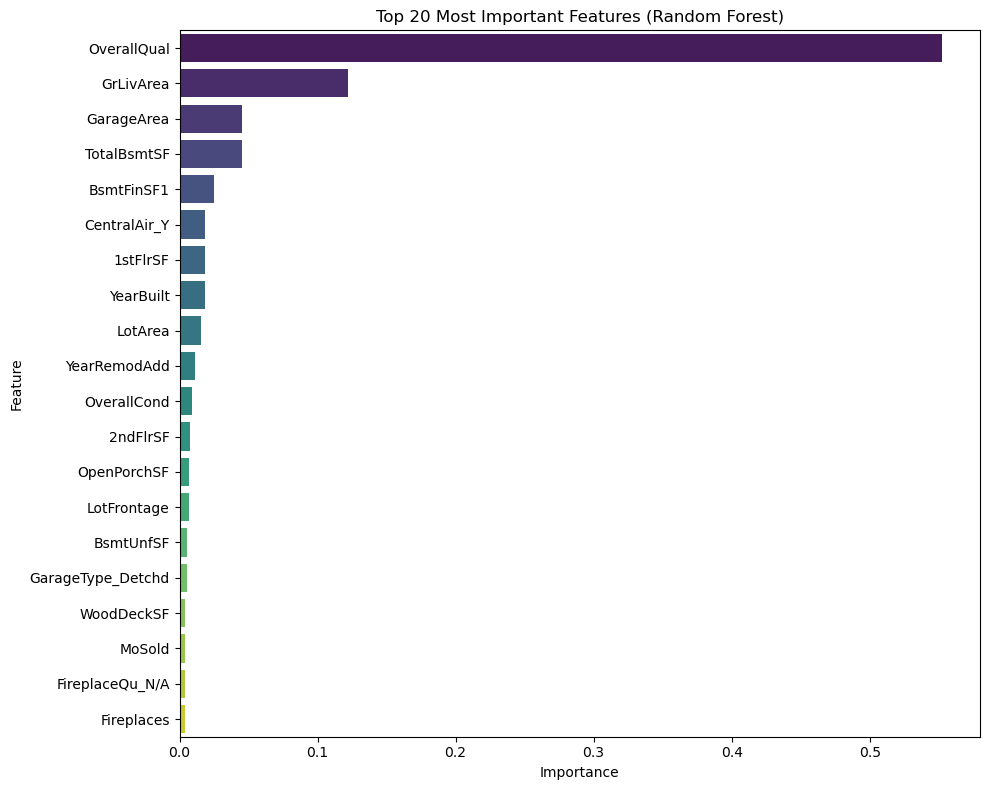

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

top_n = 20
top_features = importance_df.head(top_n)

plt.figure(figsize=(10, 8))
sns.barplot(
    data=top_features,
    y='feature',
    x='importance',
    palette='viridis',
    hue='feature',
    legend=False  # Optional: removes empty legend
)
plt.title(f'Top {top_n} Most Important Features (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Overallqual, which was the overall quality rating of the house, appears as the most important feature. Overallqual placed as second for the XGBoost analysis, so it is clearly important.

In [9]:
from sklearn.model_selection import GridSearchCV

# Define the grid of parameters to search
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Set up the model and GridSearch
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=5,
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit on training data
grid_search.fit(X_train_encoded, y_train)

# Print best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best RMSE (negative):", grid_search.best_score_)

# Save best model
best_rf_model = grid_search.best_estimator_


Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; total time=   0.0s
[CV] END bootstrap=True, max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=500; tot

/opt/anaconda3/envs/ds/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   0.4s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=500; total time=   0.7s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=500; total time=   0.9s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.4s
[CV] END bootstrap=True, max_depth=20, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   0.4s
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.4s
[CV] END bootstrap=True, max_depth=20, max_fea

/opt/anaconda3/envs/ds/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
1080 fits failed out of a total of 3240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
603 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/ds/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/ds/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/ds/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/o

Best Parameters: {'bootstrap': False, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 500}
Best RMSE (negative): -0.14263565401039574


In [10]:
from sklearn.metrics import root_mean_squared_error

best_rf_model = grid_search.best_estimator_

# Predict and evaluate on validation set
val_preds = best_rf_model.predict(X_val_encoded)
val_preds_original_scale = np.expm1(val_preds)
rmse = root_mean_squared_error(y_true, y_pred)
print(f"Validation RMSE (log-reversed): {rmse:,.2f}")

Validation RMSE (log-reversed): 32,002.81


This model is off the prices by about 32,002.81 USD. That is the same number as before so there was no improvement.

# Random Search

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

# Define the model
rf = RandomForestRegressor(random_state=42)

# Define parameter distribution
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(10, 50),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,  # increase for more thorough search
    cv=5,
    scoring='neg_root_mean_squared_error',  # directly get RMSE
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_encoded, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/opt/anaconda3/envs/ds/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
75 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
59 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/envs/ds/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/envs/ds/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/envs/ds/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/a

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x175d83620>,
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x175d0cc50>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17785ef30>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x175d82c30>},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [12]:
print("Best Parameters:", random_search.best_params_)
best_rf_model = random_search.best_estimator_

Best Parameters: {'bootstrap': False, 'max_depth': 39, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 376}


In [13]:
# Refit best model to training data (if not already done)
best_rf_model = random_search.best_estimator_

# Predict on validation set
y_val_pred_log = best_rf_model.predict(X_val_encoded)

# Convert log-predictions back to original scale
y_val_pred = np.expm1(y_val_pred_log)
y_val_actual = np.expm1(y_val)  # assuming y_val was log-transformed

# Compute RMSE
val_rmse = root_mean_squared_error(y_val_actual, y_val_pred)
print(f"Validation RMSE (log-reversed): {val_rmse:,.2f}")


Validation RMSE (log-reversed): 36,552.13


The random search parameters performed worse than the grid search parameters with 36,552.13 so I am not going to retrain the model with its hyperparameters.

# Test Dataset

In [14]:
testDF = pd.read_csv('../data/raw/train.csv')

In [15]:
testDF.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [16]:
testIds = testDF['Id']

# One-hot encode test set
X_test_encoded = pd.get_dummies(testDF, columns=cat_cols, drop_first=True)

# Align columns with training set
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Predict
test_preds_log = rf_model.predict(X_test_encoded)
test_preds_actual = np.expm1(test_preds_log)

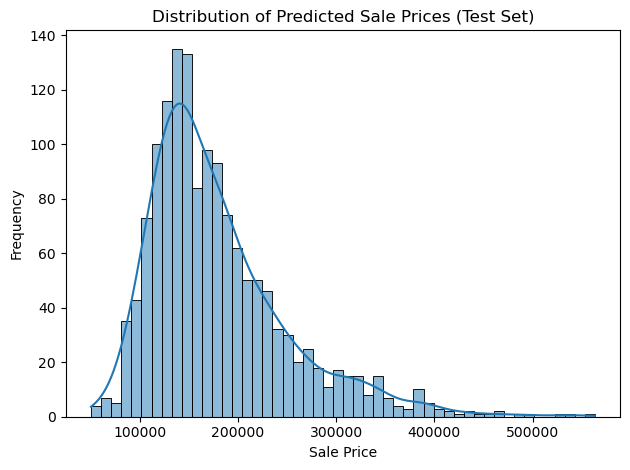

In [17]:
sns.histplot(test_preds_actual, bins=50, kde=True)
plt.title("Distribution of Predicted Sale Prices (Test Set)")
plt.xlabel("Sale Price")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [18]:
print("Predicted SalePrice Summary:")
print(f"Min: ${test_preds_actual.min():,.2f}")
print(f"Max: ${test_preds_actual.max():,.2f}")
print(f"Mean: ${test_preds_actual.mean():,.2f}")
print(f"Median: ${np.median(test_preds_actual):,.2f}")


Predicted SalePrice Summary:
Min: $50,636.90
Max: $563,377.22
Mean: $179,736.48
Median: $162,827.79
